#### <p style="color: purple;">_Decomposition Energy Plotting_</p>

In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as patches

In [2]:
## Postscript parameters
mpl.rcParams['ps.useafm'] = True
mpl.rcParams['pdf.use14corefonts'] = True
mpl.rcParams['text.usetex'] = False
mpl.rcParams['ps.fonttype'] = 42

In [3]:
def parse_input(file_path, chain_a_header, chain_b_header):
    """Read input"""
    data = pd.read_csv(file_path, delimiter='\t')
    data[f'{chain_a_header}_num'] = data[chain_a_header].str[3:].astype(int)
    data = data.sort_values(by=f'{chain_a_header}_num', ascending=False).drop(columns=f'{chain_a_header}_num')
    return data

In [4]:
def get_node_color(residue):
    """Amino acid properties"""
    residue_map = {
        'His': 'blue',    # Positively charged (His, Lys, Arg)
        'Lys': 'blue',
        'Arg': 'blue',
        'Asp': 'red',     # Negatively charged (Asp, Glu)
        'Glu': 'red',
        'Ser': 'green',   # Neutral (Ser, Thr, Asn, Gln)
        'Thr': 'green',
        'Asn': 'green',
        'Gln': 'green',
        'Ala': 'grey',    # Aliphatic (Ala, Val, Leu, Ile, Met)
        'Val': 'grey',
        'Leu': 'grey',
        'Ile': 'grey',
        'Met': 'grey',
        'Phe': 'magenta', # Aromatic (Phe, Tyr, Trp)
        'Tyr': 'magenta',
        'Trp': 'magenta',
        'Pro': 'orange',   # Proline
        'Gly': 'orange',   # Glycine
        'Cys': 'yellow'   # Cysteine
    }
    return residue_map.get(residue[:3].capitalize(), 'black')

In [5]:
def fixed_ellipse_point(x1, y1, direction, width, height):
    if direction == 'left':
        return x1 - width, y1  # Leftmost point on the ellipse boundary
    elif direction == 'right':
        return x1 + width, y1  # Rightmost point on the ellipse boundary

In [6]:
def get_edge_properties(edge_type, strength):
    """Edges properties"""
    color = 'orange' if edge_type == 'polar' else 'darkgray'
    style = 'solid' if edge_type == 'polar' else 'dotted'
    thickness = min(abs(strength) * 0.5, 1.5)  # Adjust scaling factor and cap thickness at 1.5
    return color, style, thickness

In [7]:
def add_nodes(G, data, chain_a_header, chain_b_header):
    """Add nodes"""
    for _, row in data.iterrows():
        G.add_node(f"{row[chain_a_header]}_A", label=row[chain_a_header], color=get_node_color(row[chain_a_header]))
        G.add_node(f"{row[chain_b_header]}_B", label=row[chain_b_header], color=get_node_color(row[chain_b_header]))

In [8]:
def add_edges(G, data, chain_a_header, chain_b_header):
    """Add edges"""
    for _, row in data.iterrows():
        G.add_edge(f"{row[chain_a_header]}_A", f"{row[chain_b_header]}_B", type=row['Type'], strength=row['Strength'])

In [9]:
def calculate_positions(G, data, distance, chain_a_header, chain_b_header):
    """Define header position"""
    pos = {}
    y_pos_chainA = 0
    y_pos_chainB = 0
    used_positions_chainB = set()
    
    # Mapping of chain_a_header labels to their node names
    chain_a_labels = {G.nodes[node]['label']: node for node in G.nodes() if node.endswith('_A')}
    # Mapping of chain_b_header labels to their node names
    chain_b_labels = {G.nodes[node]['label']: node for node in G.nodes() if node.endswith('_B')}
    
    for _, row in data.iterrows():
        node_a = chain_a_labels[row[chain_a_header]]
        node_b = chain_b_labels[row[chain_b_header]]
        
        if node_a not in pos:
            pos[node_a] = (-distance / 2, y_pos_chainA)
            y_pos_chainA += 1
        
        if node_b not in pos:
            # Place chain_b_header node next to its interacting chain_a_header node
            y_pos_b = pos[node_a][1]
            while y_pos_b in used_positions_chainB:
                y_pos_b += 1
            pos[node_b] = (distance / 2, y_pos_b)
            used_positions_chainB.add(y_pos_b)
    
    return pos

In [10]:
def draw_nodes(ax, G, pos):
    """Draw nodes"""
    for node, (x, y) in pos.items():
        color = G.nodes[node]['color']
        label = G.nodes[node]['label']
        ellipse = patches.Ellipse((x, y), width=1.5, height=0.5, color=color, alpha=0.9)
        ax.add_patch(ellipse)
        text_x_offset = 0.8  # Adjusted for new node size
        horizontal_alignment = 'right' if x < 0 else 'left'
        
        # Add text as vectorized text (modifiable in Illustrator)
        ax.text(x - text_x_offset if x < 0 else x + text_x_offset, y, label,
                horizontalalignment=horizontal_alignment, verticalalignment='center',
                fontsize=12, color='black', family='sans-serif', zorder=10)

In [11]:
def draw_edges(ax, pos, G):
    """Draw edges"""
    node_width = 1.5 / 2  # Half of the ellipse width
    node_height = 0.5 / 2  # Half of the ellipse height

    for u, v, d in G.edges(data=True):
        x1, y1 = pos[u]
        x2, y2 = pos[v]
        color, style, thickness = get_edge_properties(d['type'], d['strength'])

        # Set the fixed points for edges based on the node's side
        if x1 < 0:  # Node on the left side
            ex1, ey1 = fixed_ellipse_point(x1, y1, 'right', node_width, node_height)
        else:  # Node on the right side
            ex1, ey1 = fixed_ellipse_point(x1, y1, 'left', node_width, node_height)

        if x2 < 0:  # Node on the left side
            ex2, ey2 = fixed_ellipse_point(x2, y2, 'right', node_width, node_height)
        else:  # Node on the right side
            ex2, ey2 = fixed_ellipse_point(x2, y2, 'left', node_width, node_height)

        # Plot the edge between the fixed points on the ellipses
        ax.plot([ex1, ex2], [ey1, ey2], color=color, linestyle=style, linewidth=thickness)

In [12]:
def configure_plot(ax, pos, distance, chain_a_header, chain_b_header):
    """Configure plot settings"""
    all_y = [y for _, y in pos.values()]
    max_y = max(all_y) + 1  # Place title 1 unit above the highest node
    
    # Add text as vectorized text (modifiable in Illustrator)
    ax.text(-distance / 2, max_y, chain_a_header, horizontalalignment='center', verticalalignment='bottom',
            fontsize=14, color='black', fontweight='bold', family='sans-serif', zorder=10)
    ax.text(distance / 2, max_y, chain_b_header, horizontalalignment='center', verticalalignment='bottom',
            fontsize=14, color='black', fontweight='bold', family='sans-serif', zorder=10)
    
    ax.set_xlim(-distance, distance)
    ax.set_ylim(-2, max_y + 2)
    ax.set_aspect('equal')
    ax.axis('off')

In [13]:
def draw_network(data, output_file, chain_a_header, chain_b_header):
    """Draw the network"""
    G = nx.Graph()
    add_nodes(G, data, chain_a_header, chain_b_header)
    add_edges(G, data, chain_a_header, chain_b_header)
    distance = 6  # Change this value to increase/decrease the distance between ChainA and ChainB nodes
    pos = calculate_positions(G, data, distance, chain_a_header, chain_b_header)
    fig, ax = plt.subplots(figsize=(12, 8))
    draw_nodes(ax, G, pos)
    draw_edges(ax, pos, G)
    configure_plot(ax, pos, distance, chain_a_header, chain_b_header)
    plt.savefig(output_file, bbox_inches='tight')

In [14]:
def draw_network_ps(data, output_file, chain_a_header, chain_b_header):
    """Draw the network and save it to a PostScript file"""
    G = nx.Graph()
    add_nodes(G, data, chain_a_header, chain_b_header)
    add_edges(G, data, chain_a_header, chain_b_header)
    distance = 4
    pos = calculate_positions(G, data, distance, chain_a_header, chain_b_header)
    
    # Figure size
    fig, ax = plt.subplots(figsize=(12, 10))
    
    # Draw the nodes and edges
    draw_nodes(ax, G, pos)
    draw_edges(ax, pos, G)
    
    # Configure plot with vectorized text
    configure_plot(ax, pos, distance, chain_a_header, chain_b_header)
    
    # Save as PostScript file with vectorized text
    plt.savefig(output_file, format='ps', dpi=300, bbox_inches='tight')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


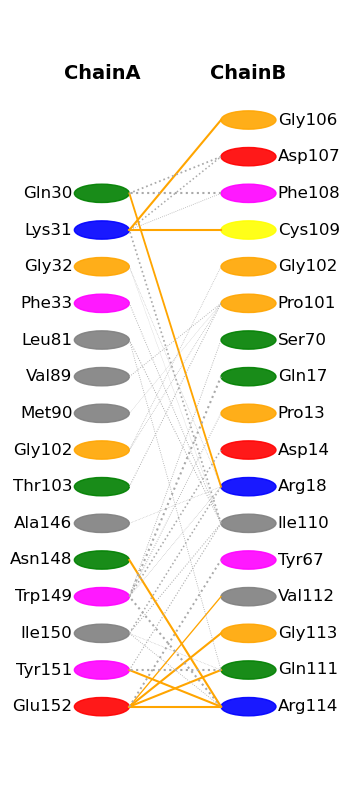

In [15]:
## Generate postscript
input_file = 'plot/interaction.in'
output_file_ps = 'plot/node_nme1_ab.ps'

# Specify the headers
chain_a_header = 'ChainA'
chain_b_header = 'ChainB'

data = parse_input(input_file, chain_a_header, chain_b_header)
draw_network_ps(data, output_file_ps, chain_a_header, chain_b_header)